In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [59]:
df = pd.read_csv('/content/drive/MyDrive/ML Project/ratings_data.csv')
df['date'] = pd.to_datetime(df['date'], unit='s')
df.sort_values(by=['reviewerID', 'date'], inplace=True)
df.head()

,rating,reviewerID,product_id,date
19365,4,A0004478EF5NFPHLGCWG,B0001XXB3E,2013-01-17
576678,4,A0004478EF5NFPHLGCWG,B005H40QQC,2013-01-17
245606,4,A0004478EF5NFPHLGCWG,B001792ULU,2013-07-29
303137,4,A0004478EF5NFPHLGCWG,B001792ULU,2013-07-29
530174,4,A0004478EF5NFPHLGCWG,B004TT6LA6,2013-07-29


In [75]:
#remove rows from df containing all certain product_id, which has less than 1000 count
df = df[~df['product_id'].isin(df['product_id'].value_counts()[df['product_id'].value_counts() < 590].index)]

mapping the product id to numbers as there are strings in it

In [76]:
product_ids = df['product_id'].unique()
product_id_map = {product_id: i + 1 for i, product_id in enumerate(product_ids)}

In [77]:
len(product_ids)

140

Split the data into train and test sets based on 'reviewerID' to avoid overlap<br>
so to achive that i have used groupshufflesplit

In [78]:
# Split the data into train and test sets based on 'reviewerID' to avoid overlap
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['reviewerID']))
train_df = df.iloc[train_idx]
test_df = df.iloc[test_idx]


making sure that groupshuffle actually split the data.<br>
added this as in first iteration of my code it was not working as intended

In [79]:
train_reviewers = set(train_df['reviewerID'])
test_reviewers = set(test_df['reviewerID'])
assert len(train_reviewers.intersection(test_reviewers)) == 0, "There is overlap between train and test reviewerIDs!"

## process data

In [80]:
def process_data(df, seqlen):
    user_groups = df.groupby('reviewerID')
    X_train, y_train_products, y_train_ratings = [], [], []
    j = 0 #for checking progress
    for user, user_data in user_groups:
        user_data = user_data.sort_values(by='date')
        product_sequence = user_data['product_id'].values
        rating_sequence = user_data['rating'].values

        for i in range(1, len(product_sequence)):
            X_train.append(product_sequence[:i])
            y_train_products.append(product_sequence[i])
            y_train_ratings.append(rating_sequence[i])
            if j%10000 == 0:
                print(j)
            j+=1

    # use the above created map to replace int values
    # padded them so that i can give to model
    X_mapped = [[product_id_map[prod] for prod in x] for x in X_train]
    X_padded = pad_sequences(X_mapped, maxlen=seqlen)

    y_mapped_products = np.array([product_id_map[prod] for prod in y_train_products], dtype=np.int32)
    y_ratings = np.array(y_train_ratings, dtype=np.float32)

    return X_padded, y_mapped_products, y_ratings


In [81]:
# i have chosen 3 as hyperparameter, the process data will generate me training
# set including all 1,2,3 combinations for coldstart
seqlen = 3
X_train_padded, y_train_products, y_train_ratings = process_data(train_df, seqlen)

0
10000
20000
30000
40000
50000
60000
70000


In [91]:
# Define the model
input_layer = Input(shape=(seqlen,))

In [92]:
# Embedding layer
embedding_layer = Embedding(input_dim=len(product_id_map) + 1, output_dim=50)(input_layer)

In [93]:
# LSTM layer
lstm_layer = LSTM(256, activation='relu', kernel_regularizer=l1_l2(l1=0.02, l2=0.02))(embedding_layer)

In [94]:
# Dropout layer
dropout_layer = Dropout(0.8)(lstm_layer)

In [95]:
# Output layers: product prediction (classification) and rating prediction (regression)
product_output = Dense(len(product_id_map) + 1, activation='softmax', name='product_output')(dropout_layer)
rating_output = Dense(1, activation='linear', name='rating_output')(dropout_layer)


In [96]:
# Build and compile the model
model = Model(inputs=input_layer, outputs=[product_output, rating_output])
model.compile(optimizer='adam',
              loss={'product_output': 'sparse_categorical_crossentropy', 'rating_output': 'mean_squared_error'},
              metrics={'product_output': 'accuracy', 'rating_output': 'mae'})

In [97]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [98]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, 3, 50)          │          7,050 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 256)            │        314,368 │ embedding_5[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 256)            │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ product_output (Dense)    │ (None, 141)            │         36,237 │ dropout_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rating_output (Dense)     │ (None, 1)              │            257 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 357,912 (1.37 MB)

 Trainable params: 357,912 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

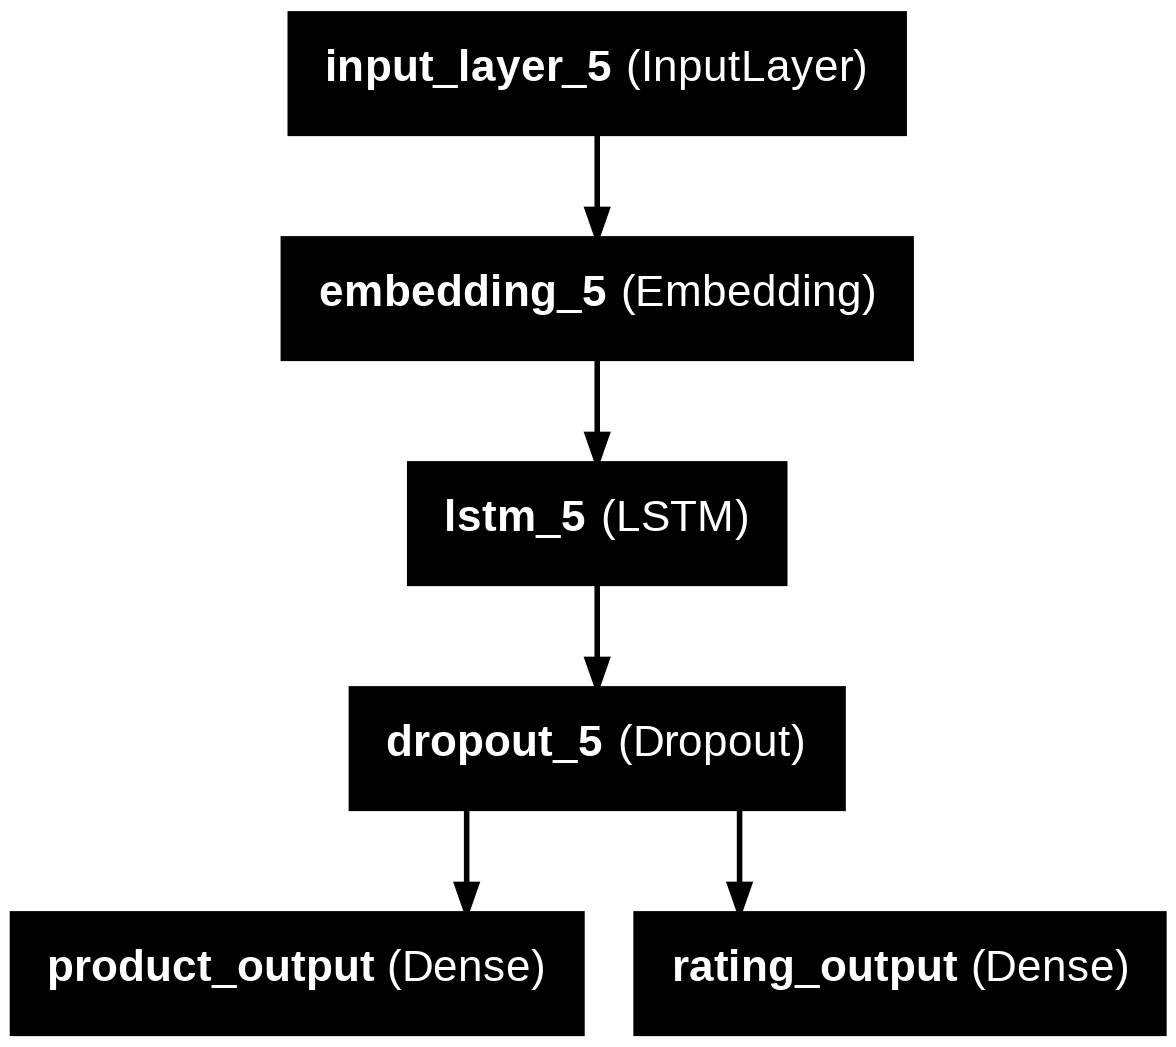

In [99]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='plot.png', show_layer_names=True)

In [100]:
# Train the model
model.fit(X_train_padded, {'product_output': y_train_products, 'rating_output': y_train_ratings},
          validation_split=0.2, epochs=100, batch_size=64, callbacks=[early_stopping])

Epoch 1/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 14.1805 - product_output_accuracy: 0.0577 - rating_output_mae: 1.4915 - val_loss: 5.5836 - val_product_output_accuracy: 0.0667 - val_rating_output_mae: 0.8106
Epoch 2/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.1774 - product_output_accuracy: 0.0657 - rating_output_mae: 0.9434 - val_loss: 5.5332 - val_product_output_accuracy: 0.0667 - val_rating_output_mae: 0.7501
Epoch 3/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6.0714 - product_output_accuracy: 0.0687 - rating_output_mae: 0.9113 - val_loss: 5.5285 - val_product_output_accuracy: 0.0667 - val_rating_output_mae: 0.7508
Epoch 4/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.9808 - product_output_accuracy: 0.0664 - rating_output_mae: 0.8794 - val_loss: 5.5868 - val_product_output_accuracy: 0.0667 - val_rating_output_mae: 0.8176
Epoch 5/100
916/916 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.9313 - product_output_accuracy: 0.0693 - rating_output_mae:

the processing of training data was different need so creating another one for test

In [101]:
def process_test_data(df, seqlen):
    user_groups = df.groupby('reviewerID')
    X_test, y_test_products, y_test_ratings = [], [], []
    j = 0 #for checking progress
    for user, user_data in user_groups:
        user_data = user_data.sort_values(by='date')
        product_sequence = user_data['product_id'].values
        rating_sequence = user_data['rating'].values

        for i in range(1, len(product_sequence)):
            X_test.append(product_sequence[:i])
            y_test_products.append(product_sequence[i])
            y_test_ratings.append(rating_sequence[i])
            if j%10000 == 0:
                print(j)
            j+=1

    # use the above created map to replace int values
    # padded them so that i can give to model
    X_mapped = [[product_id_map[prod] for prod in x] for x in X_test]
    X_padded = pad_sequences(X_mapped, maxlen=seqlen)

    y_mapped_products = np.array([product_id_map[prod] for prod in y_test_products], dtype=np.int32)
    y_ratings = np.array(y_test_ratings, dtype=np.float32)

    return X_padded, y_mapped_products, y_ratings


In [102]:
X_test_padded, y_test_products, y_test_ratings = process_test_data(test_df, seqlen)


0
10000


In [103]:
# Make predictions and evaluate
predicted_product_ids = []
predicted_ratings = []

batch_size = 2048
jay = 0
for i in range(0, len(X_test_padded), batch_size):
    input_batch = X_test_padded[i:i + batch_size]
    predicted_product, predicted_rating = model.predict(input_batch, batch_size=batch_size)

    predicted_product_ids.extend(np.argmax(predicted_product, axis=1))
    predicted_ratings.extend(predicted_rating[:, 0])
    print(jay)
    jay+=1
    K.clear_session()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
8


In [106]:
# Evaluate the predictions
mae = mean_absolute_error(y_test_ratings, predicted_ratings)
mse = mean_squared_error(y_test_ratings, predicted_ratings)
rmse = np.sqrt(mse)
product_accuracy = np.mean(np.array(predicted_product_ids) == y_test_products)

print(f"MAE for ratings: {mae}")
print(f"RMSE for ratings: {rmse}")
print(f"Accuracy for product prediction: {product_accuracy}")


MAE for ratings: 0.7117999792098999
RMSE for ratings: 0.9802572727203369
Accuracy for product prediction: 0.5987984346579949


In [105]:
# save the model, so i dont have to train it again and again
model.save('/content/drive/MyDrive/ML Project/phase2.keras')